In [24]:
import pandas as pd
import geopandas as gpd
import numpy as np

# =========================
# Carregar shapefiles
# =========================
gdf_model = gpd.read_file(
    r"../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model_Outubro.shp"
)

gdf_log = gpd.read_file(
    r"../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model_log.shp"
)

df_model = pd.DataFrame(gdf_model.drop(columns="geometry"))
df_log = pd.DataFrame(gdf_log.drop(columns="geometry"))

# =========================
# Inicialização
# =========================
ros_col = "ros_p"
correlations_data = {}

vars_model = [c for c in df_model.columns if c != ros_col]
vars_log = [c for c in df_log.columns if c != ros_col]

common_vars = list(set(vars_model).intersection(set(vars_log)))

# =========================
# Calcular correlações
# =========================
for var in common_vars:

    if var not in correlations_data:
        correlations_data[var] = {"variable": var}

    # Linear: ROS vs X
    correlations_data[var]["corr_ros_p_model"] = (
        df_model[[ros_col, var]].dropna().corr().iloc[0, 1]
    )

    # Exponencial: log(ROS) vs X
    correlations_data[var]["corr_log_ros_p_model"] = (
        df_log[[ros_col]].join(df_model[var]).dropna().corr().iloc[0, 1]
    )

    # Logarítmica: ROS vs log(X)
    correlations_data[var]["corr_ros_p_model_log"] = (
        df_model[[ros_col]].join(df_log[var]).dropna().corr().iloc[0, 1]
    )

    # Potência: log(ROS) vs log(X)
    correlations_data[var]["corr_log_ros_p_model_log"] = (
        df_log[[ros_col, var]].dropna().corr().iloc[0, 1]
    )

# =========================
# Criar DataFrame consolidado
# =========================
correlations_df = pd.DataFrame(correlations_data.values())

desired_columns = [
    "variable",
    "corr_ros_p_model",
    "corr_log_ros_p_model",
    "corr_ros_p_model_log",
    "corr_log_ros_p_model_log"
]

for col in desired_columns:
    if col not in correlations_df.columns:
        correlations_df[col] = np.nan

correlations_df = correlations_df[desired_columns]

# =========================
# Determinar tipo de relação
# =========================
correlations_df["Relation"] = ""

for idx, row in correlations_df.iterrows():

    corr_values = {}

    if not pd.isna(row["corr_ros_p_model"]):
        corr_values["L ROS - L var"] = abs(row["corr_ros_p_model"])

    if not pd.isna(row["corr_log_ros_p_model"]):
        corr_values["Log ROS - L var"] = abs(row["corr_log_ros_p_model"])

    if not pd.isna(row["corr_ros_p_model_log"]):
        corr_values["L ROS - Log var"] = abs(row["corr_ros_p_model_log"])

    if not pd.isna(row["corr_log_ros_p_model_log"]):
        corr_values["Log ROS - Log var"] = abs(row["corr_log_ros_p_model_log"])

    if corr_values:
        max_corr_type = max(corr_values, key=corr_values.get)

        if max_corr_type == "L ROS - L var":
            correlations_df.at[idx, "Relation"] = "Relação Linear"
        elif max_corr_type == "Log ROS - L var":
            correlations_df.at[idx, "Relation"] = "Relação Exponencial"
        elif max_corr_type == "L ROS - Log var":
            correlations_df.at[idx, "Relation"] = "Relação Logarítmica"
        elif max_corr_type == "Log ROS - Log var":
            correlations_df.at[idx, "Relation"] = "Relação Potência"
    else:
        correlations_df.at[idx, "Relation"] = "Sem dados suficientes"

# =========================
# Exportar
# =========================
output_file = "../../Data/Data_Exploration/all_ros_p_correlations.csv"
correlations_df.to_csv(output_file, index=False)

print(f"Successfully created {output_file}")
print(f"Total variables: {len(correlations_df)}")

print("\n=== DISTRIBUIÇÃO DAS RELAÇÕES ===")
relation_counts = correlations_df["Relation"].value_counts()
for relation_type, count in relation_counts.items():
    print(f"{relation_type}: {count} variáveis ({count/len(correlations_df)*100:.1f}%)")

print("\nPrimeiras 10 linhas do DataFrame:")
print(correlations_df.head(10))


Successfully created ../../Data/Data_Exploration/all_ros_p_correlations.csv
Total variables: 86

=== DISTRIBUIÇÃO DAS RELAÇÕES ===
Relação Potência: 54 variáveis (62.8%)
Relação Exponencial: 13 variáveis (15.1%)
Relação Linear: 10 variáveis (11.6%)
Relação Logarítmica: 9 variáveis (10.5%)

Primeiras 10 linhas do DataFrame:
     variable  corr_ros_p_model  corr_log_ros_p_model  corr_ros_p_model_log  \
0  LiftIdx_av         -0.193654             -0.135102              0.044373   
1      Recirc         -0.219484              0.022409             -0.076405   
2    sW_3m_av         -0.152149              0.014333             -0.078418   
3  TotCC_p_av          0.091742              0.110469              0.076982   
4    land_use         -0.088047              0.048183             -0.108359   
5   t_2m_C_av          0.224533              0.095355             -0.075707   
6   rh_500_av          0.052333              0.113307             -0.029451   
7   sW_289_av         -0.158441            

In [25]:
# =========================
# Top 20 variáveis por |corr|
# =========================

correlations_df["max_abs_corr"] = correlations_df[
    [
        "corr_ros_p_model",
        "corr_log_ros_p_model",
        "corr_ros_p_model_log",
        "corr_log_ros_p_model_log"
    ]
].abs().max(axis=1)

top20 = correlations_df.sort_values(
    by="max_abs_corr",
    ascending=False
).head(50)

print("\n=== TOP 20 VARIÁVEIS COM MAIOR |CORRELAÇÃO| ===")
print(
    top20[
        [
            "variable",
            "max_abs_corr",
            "Relation",
            "corr_ros_p_model",
            "corr_log_ros_p_model",
            "corr_ros_p_model_log",
            "corr_log_ros_p_model_log"
        ]
    ].to_string(index=False)
)



=== TOP 20 VARIÁVEIS COM MAIOR |CORRELAÇÃO| ===
  variable  max_abs_corr            Relation  corr_ros_p_model  corr_log_ros_p_model  corr_ros_p_model_log  corr_log_ros_p_model_log
 ros_p_lg1      0.596109    Relação Potência          0.382847              0.120793              0.024144                  0.596109
duration_p      0.428797      Relação Linear         -0.428797              0.001115             -0.064146                 -0.428094
wv100_k_av      0.389013    Relação Potência          0.225740             -0.109829              0.047050                  0.389013
    HDW_av      0.372063    Relação Potência          0.365408             -0.007547             -0.026657                  0.372063
wv10_kh_av      0.352570    Relação Potência          0.257011             -0.076981              0.032507                  0.352570
  rh_2m_av      0.343995    Relação Potência         -0.225312             -0.039965              0.040393                 -0.343995
   dfmc_av      0.34

In [26]:
# Parâmetros
top_n = 15

# Para cada coluna de correlação
for col in ['corr_ros_p_model', 'corr_log_ros_p_model', 'corr_ros_p_model_log', 'corr_log_ros_p_model_log']:
    if col in correlations_df.columns:
        # Remover NaN e ordenar por valor absoluto
        df_filtrado = correlations_df.dropna(subset=[col])
        top_vars = df_filtrado.reindex(df_filtrado[col].abs().sort_values(ascending=False).index).head(top_n)
        
        print(f"\nTop {top_n} |{col}|:")
        print(top_vars[['variable', col]])


Top 15 |corr_ros_p_model|:
      variable  corr_ros_p_model
61  duration_p         -0.428797
23   ros_p_lg1          0.382847
44      HDW_av          0.365408
76  wv10_kh_av          0.257011
28   VPD_Pa_av          0.254450
31    BLH_m_av          0.252962
39     dfmc_av         -0.231406
29  wv100_k_av          0.225740
18    rh_2m_av         -0.225312
5    t_2m_C_av          0.224533
1       Recirc         -0.219484
33     CircVar         -0.212148
77   gT_s_9_av         -0.211820
52    LCL_m_av          0.208558
15  LCL_hPa_av         -0.205692

Top 15 |corr_log_ros_p_model|:
      variable  corr_log_ros_p_model
0   LiftIdx_av             -0.135102
53    wSv_1_av             -0.121489
23   ros_p_lg1              0.120793
63   wv_950_av             -0.115529
6    rh_500_av              0.113307
22     sW_7_av              0.112978
3   TotCC_p_av              0.110469
29  wv100_k_av             -0.109829
27  HigCC_p_av              0.105396
81   gp_850_av              0.105227
30   

In [27]:
# =========================
# Compute strongest correlation per variable
# =========================
corr_cols = [
    "corr_ros_p_model",
    "corr_log_ros_p_model",
    "corr_ros_p_model_log",
    "corr_log_ros_p_model_log"
]

def get_max_corr(row):
    vals = row[corr_cols].dropna()
    if vals.empty:
        return pd.Series([np.nan, np.nan])
    max_val = vals.loc[vals.abs().idxmax()]
    return pd.Series([max_val, abs(max_val)])

correlations_df[["max_corr", "max_abs_corr"]] = correlations_df.apply(
    get_max_corr, axis=1
)

# =========================
# Filter for plotting
# =========================
plot_df = correlations_df[correlations_df["max_abs_corr"] > 0.25].copy()
plot_df = plot_df.sort_values("max_abs_corr", ascending=False)

plot_df = plot_df.loc[~plot_df['variable'].isin(['inidoy', 'enddoy'])]


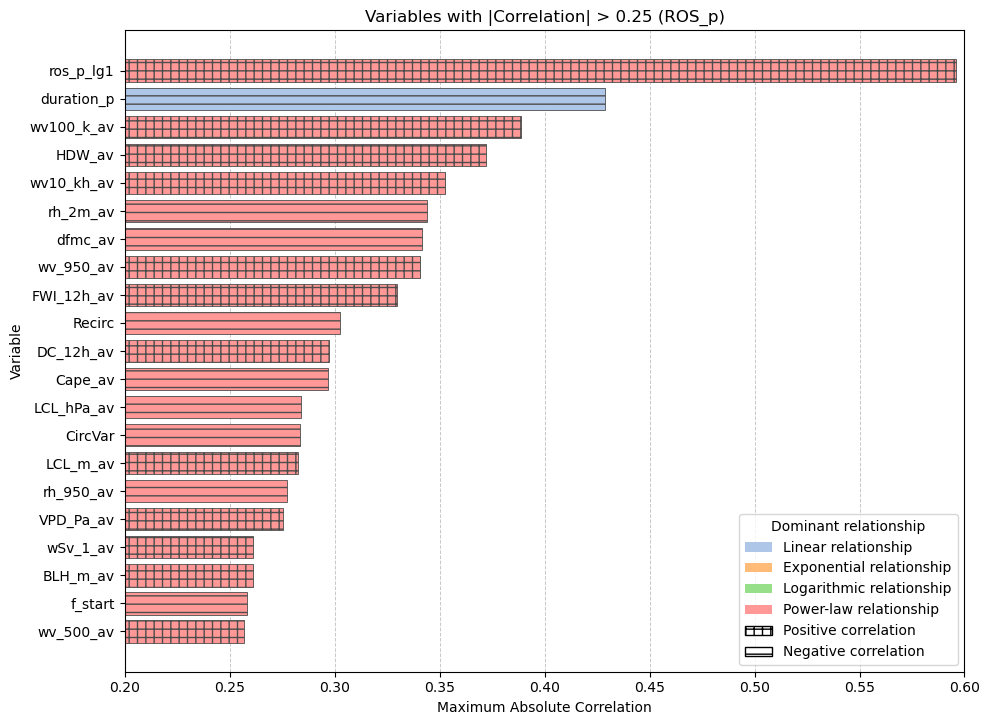

In [41]:
# =========================
# Bar plot of strongest correlations (refined style)
# =========================
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ---- Pastel color palette by relationship type ----
relation_colors = {
    "Relação Linear": "#AEC7E8",        # pastel blue
    "Relação Exponencial": "#FFBB78",   # pastel orange
    "Relação Logarítmica": "#98DF8A",   # pastel green
    "Relação Potência": "#FF9896"       # pastel red
}

plot_df["color"] = plot_df["Relation"].map(relation_colors)

# ---- Hatch mapping (lighter texture) ----
plot_df["hatch"] = plot_df["max_corr"].apply(lambda x: "+" if x > 0 else "-")

# =========================
# Plot
# =========================
fig, ax = plt.subplots(figsize=(10, max(6, 0.35 * len(plot_df))))

bars = ax.barh(
    plot_df["variable"],
    plot_df["max_abs_corr"],
    color=plot_df["color"],
    edgecolor="0.3",
    linewidth=0.6
)

# Apply lighter hatches
for bar, hatch in zip(bars, plot_df["hatch"]):
    bar.set_hatch(hatch * 2)

# ---- Gridlines ----
ax.grid(
    axis="x",
    linestyle="--",
    linewidth=0.7,
    alpha=0.7
)
ax.set_axisbelow(True)

# ---- Labels & title ----
ax.set_xlabel("Maximum Absolute Correlation")
ax.set_ylabel("Variable")
ax.set_title("Variables with |Correlation| > 0.25 (ROS_p)")
ax.set_xlim(0.2, 0.6)

ax.invert_yaxis()

# ---- Legend (English) ----
legend_elements = [
    Patch(facecolor=relation_colors["Relação Linear"], label="Linear relationship"),
    Patch(facecolor=relation_colors["Relação Exponencial"], label="Exponential relationship"),
    Patch(facecolor=relation_colors["Relação Logarítmica"], label="Logarithmic relationship"),
    Patch(facecolor=relation_colors["Relação Potência"], label="Power-law relationship"),
    Patch(facecolor="white", edgecolor="black", hatch="++", label="Positive correlation"),
    Patch(facecolor="white", edgecolor="black", hatch="--", label="Negative correlation"),
]

ax.legend(
    handles=legend_elements,
    title="Dominant relationship",
    loc="lower right",
    frameon=True
)

plt.tight_layout()
plt.show()
